# More Bayesian Examples with PyMC

Today, we shall look at more examples of Bayesian data analyses using PyMC. 

In [1]:
#Import the necessary libraries:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

## Example: Normal Mean Estimation

A simple experiment to measure the length of an object led to the following 15 measurements: $17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61$. What is the best estimate for the length of this object? 

We can solve this problem using the following Bayesian model. Let $\theta$ denote the unknown true length that we are trying to obtain. We shall assume the prior: $\theta \in \text{uniform}[0, 30]$ (it is obvious from the measurements that $\theta$ should like between 0 and 30 so the $\text{uniform}[0, 30]$ prior is really an "uninformative" prior; uninformative basically means that the prior reveals very little nontrivial information about the parameter).


In [2]:
n = 15
y_obs = np.array([17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61])

measurement_model = pm.Model()
with measurement_model:
    theta = pm.Uniform("theta", lower = 0, upper = 30)
    log_sigma = pm.Uniform("log_sigma", lower = -10, upper = 0)
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    Y = pm.Normal("Y", mu = theta, sd = sigma, observed=y_obs)
    #Sample from posterior:
    idata = pm.sample(10000, chains = 2, return_inferencedata = True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_sigma, theta]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


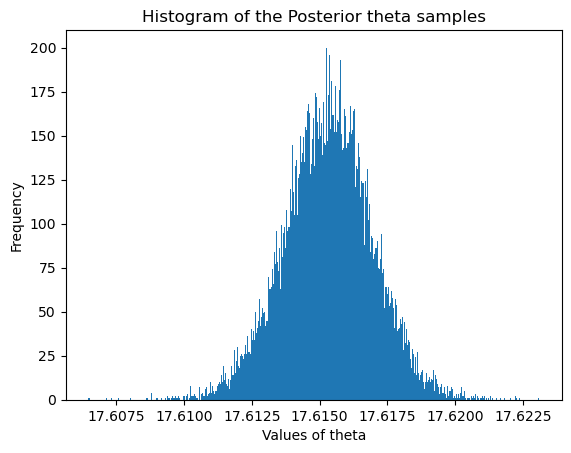

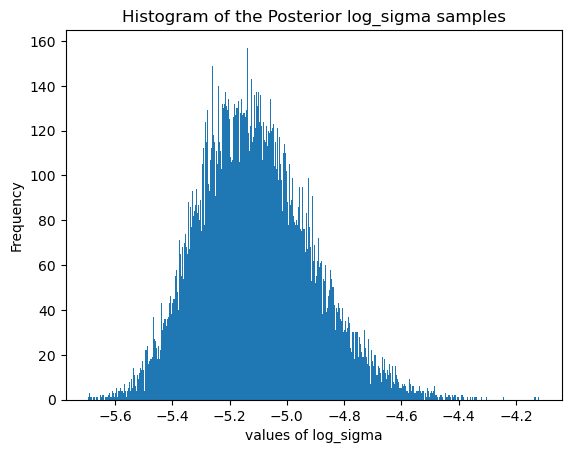

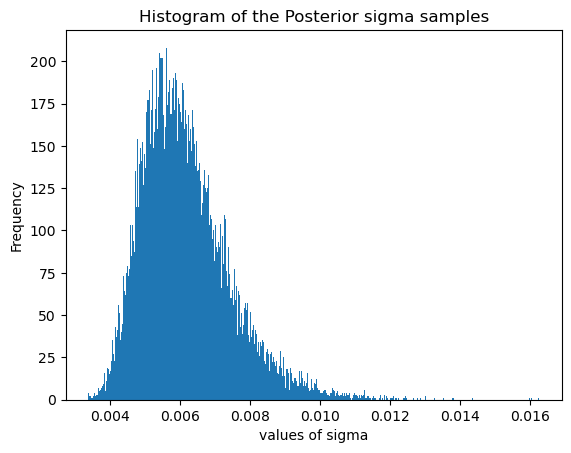

In [4]:
theta_samples = idata.posterior['theta'].values.flatten()
log_sigma_samples = idata.posterior['log_sigma'].values.flatten()
#Histogram of posterior theta samples for theta
plt.hist(theta_samples, bins = 500)
plt.xlabel('Values of theta')
plt.ylabel('Frequency')
plt.title('Histogram of the Posterior theta samples')
plt.show();

#Histogram of posterior log_sigma samples
plt.hist(log_sigma_samples, bins = 500)
plt.xlabel('values of log_sigma')
plt.ylabel('Frequency')
plt.title('Histogram of the Posterior log_sigma samples')
plt.show();

#Posterior samples for sigma are obtained by exponentiating the log_sigma samples
sigma_samples = np.exp(log_sigma_samples)
plt.hist(sigma_samples, bins = 500)
plt.xlabel('values of sigma')
plt.ylabel('Frequency')
plt.title('Histogram of the Posterior sigma samples')
plt.show();

In [5]:
#Our best estimate of the unknown length can be taken to be the mean of the posterior samples for theta:
thetamean = np.mean(theta_samples)
display(thetamean)
#Our uncertainty in theta can be captured by the standard deviation of the posterior samples
thetastd = np.std(theta_samples)
display(thetastd)
#Our best estimate for sigma (which can be interpreted as the uncertainty in each individual measurement) can be obtained 
#by taking the mean of the posterior samples for sigma:
sigmamean = np.mean(sigma_samples)
display(sigmamean)

17.615317689084797

0.0016474895781419198

0.006158982013397058

In [6]:
#A 95% interval for theta based on the posterior samples is computed as follows:
lower_limit_theta = np.percentile(theta_samples, 2.5)
upper_limit_theta = np.percentile(theta_samples, 97.5)
display(lower_limit_theta, upper_limit_theta)

#Similarly, A 95% interval for sigma based on the posterior samples is computed as follows:
lower_limit_sigma = np.percentile(sigma_samples, 2.5)
upper_limit_sigma = np.percentile(sigma_samples, 97.5)
display(lower_limit_sigma, upper_limit_sigma)

17.61204156580953

17.61851532074465

0.004244759313478731

0.009240988371002228

## With Some Erroneous Observations

We will now throw in some erroneous observations and see if they can be detected. 


In [7]:
y_obs = np.array([17.62, 17.61, 17.61, 17.62, 17.62, 17.615, 17.615, 17.625, 17.61, 17.62, 17.62, 17.605, 17.61, 17.62, 17.61, 25, 31])
n = len(y_obs)
print(n)

17


In [8]:
measurement_somefake_model = pm.Model()
with measurement_somefake_model:
    w1 = pm.Beta("w1", alpha = 1, beta = 1)
    theta = pm.Uniform("theta", lower = 0, upper = 30)
    log_sigma = pm.Uniform("log_sigma", lower = -10, upper = 0)
    sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
    
    theta2 = 0
    sigma2 = 100
    
    thetas = pm.math.stack([theta, theta2])
    sigmas = pm.math.stack([sigma, sigma2])

    category = pm.Bernoulli("category", p = w1, shape = n)
    mean_idx = thetas[category]
    sd_idx = sigmas[category]
    obs = pm.Normal("obs", mu = mean_idx, sd = sd_idx, observed = y_obs)
    idata = pm.sample(1000, chains = 2, return_inferencedata = True)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [log_sigma, theta, w1]
>BinaryGibbsMetropolis: [category]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [9]:
w1_samples = idata.posterior['w1'].values.flatten()
print(w1_samples)
w1mean = np.mean(w1_samples)
w1std = np.std(w1_samples)
display(w1mean, w1std)

[0.10958326 0.09587954 0.09587954 ... 0.08954403 0.14632413 0.07794744]


0.15900279394321307

0.08367732874653809

In [10]:
theta_samples = idata.posterior['theta'].values.flatten()
print(np.mean(theta_samples))
print(np.std(theta_samples))
sigma_samples = idata.posterior['sigma'].values.flatten()
print(np.mean(sigma_samples))
print(np.mean(y_obs))

17.615312407369697
0.001663348108315898
0.006236812334180699
18.837058823529414


In [11]:
print(idata.posterior['category'].shape)
category_samples_onepoint = idata.posterior['category'][:, :, 1].values.flatten()
print(category_samples_onepoint)

(2, 1000, 17)
[0 0 0 ... 0 0 0]


In [12]:
category_samples = idata.posterior['category'].values
combined_samples = category_samples.reshape(-1, n)
print(combined_samples.shape)
category_means = np.mean(combined_samples, axis = 0)
category_sums = np.sum(combined_samples, axis = 0)
print(category_sums)
print(category_means)

(2000, 17)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 2000 2000]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


## Exoplanet Data Analysis

Here fit a normal mixture model with two components. 

In [13]:
dplan = pd.read_csv('exoplanets.csv')
print(dplan.head(10))
#The variables in this dataset are radius, mass, density, orbital period and
#temperature of the star around which the planet orbits.
#We shall only work with the radius variable. 
#Radius is measured in multiples of Earth's radius

                          name  orbital_period         mass     radius  \
0  2MASS J21402931+1625183 A b     7336.500000  6657.910000  10.312188   
1                     55 Cnc e        0.736539     8.078476   1.905513   
2                  BD+20 594 b       41.685500    16.299962   2.230571   
3                    CoRoT-1 b        1.508956   327.334000  16.701261   
4                   CoRoT-10 b       13.240600   873.950000  10.872633   
5                   CoRoT-11 b        2.994330   740.474000  16.028727   
6                   CoRoT-12 b        2.828042   291.422600  16.140816   
7                   CoRoT-13 b        4.035190   415.682400   9.919877   
8                   CoRoT-14 b        1.512140  2415.280000  12.217701   
9                   CoRoT-16 b        5.352270   170.023000  13.114413   

   star_temperature  density  
0            2300.0      NaN  
1            5196.0    6.400  
2            5766.0    7.890  
3            5950.0    0.380  
4            5075.0    3.700  

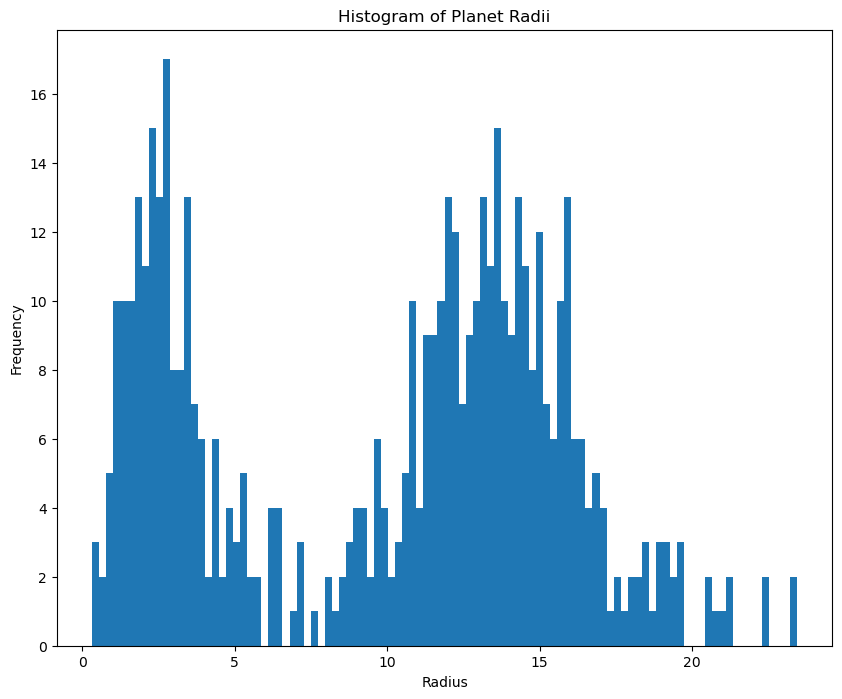

In [14]:
#Let us plot the histogram of the radii:
plt.figure(figsize=(10, 8))
plt.hist(dplan['radius'], bins = 100)
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.title('Histogram of Planet Radii')
plt.show()
#Clearly there are two groups of planet radii: Big planets and Small planets. 

In [15]:
#Fitting a Gaussian mixture model using pymc
#N = dplan_no_missing.shape[0]
#observed = dplan_no_missing['pl_radj']
N = dplan.shape[0]
exoplanet_model = pm.Model()
with exoplanet_model:
    w1 = pm.Beta("w1", alpha = 1, beta = 1)
    thetas = pm.Normal("thetas", mu = np.array([2, 14]), sd = 10, shape = 2)
    sigmas = pm.HalfNormal("sigmas", sd = 10, shape = 2) #The HalfNormal distribution is the absolute value of the Normal
    category = pm.Bernoulli("category", p = w1, shape = N)
    mean_individual = thetas[category]
    sd_individual = sigmas[category]
    obs = pm.Normal("obs", mu = mean_individual, sd = sd_individual, observed = dplan['radius'])
    idata = pm.sample(1000, chains = 2, return_inferencedata = True)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [sigmas, thetas, w1]
>BinaryGibbsMetropolis: [category]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 25% for some parameters.


In [16]:
print(idata.posterior)
#Calculate posterior means of w1, thetas and sigmas:
w1_samples = idata.posterior['w1'].values.flatten()
w1mean = np.mean(w1_samples)

thetas_samples = idata.posterior['thetas'].values
combined_thetas_samples = thetas_samples.reshape(-1, 2)
print(combined_thetas_samples.shape)
thetas_means = np.mean(combined_thetas_samples, axis = 0)

sigmas_samples = idata.posterior['sigmas'].values
combined_sigmas_samples = sigmas_samples.reshape(-1, 2)
print(combined_sigmas_samples.shape)
sigmas_means = np.mean(combined_sigmas_samples, axis = 0)

print(w1mean, thetas_means, sigmas_means)

<xarray.Dataset>
Dimensions:         (chain: 2, draw: 1000, thetas_dim_0: 2, category_dim_0: 517, sigmas_dim_0: 2)
Coordinates:
  * chain           (chain) int64 0 1
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * thetas_dim_0    (thetas_dim_0) int64 0 1
  * category_dim_0  (category_dim_0) int64 0 1 2 3 4 5 ... 512 513 514 515 516
  * sigmas_dim_0    (sigmas_dim_0) int64 0 1
Data variables:
    thetas          (chain, draw, thetas_dim_0) float64 2.609 13.61 ... 13.75
    category        (chain, draw, category_dim_0) int64 1 0 0 1 1 ... 1 1 1 1 1
    w1              (chain, draw) float64 0.6878 0.6426 0.7051 ... 0.688 0.6318
    sigmas          (chain, draw, sigmas_dim_0) float64 1.283 3.125 ... 3.065
Attributes:
    created_at:                 2023-09-21T22:11:59.954739
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              59.997132539749146
    tuning_ste

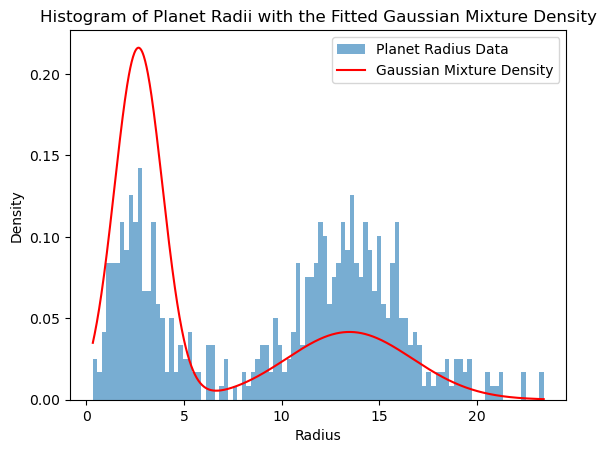

In [17]:
#Let us plot the fitted two component normal mixture density on the histogram (to visualize the fit):
from scipy.stats import norm

plt.hist(dplan['radius'], bins = 100, density = True, alpha = 0.6, label = 'Planet Radius Data')
x = np.linspace(min(dplan['radius']), max(dplan['radius']), 1000)
density = w1mean * norm.pdf(x, thetas_means[0], sigmas_means[0]) + (1-w1mean) * norm.pdf(x, thetas_means[1], sigmas_means[1])
plt.plot(x, density, 'r', label = 'Gaussian Mixture Density')
plt.title('Histogram of Planet Radii with the Fitted Gaussian Mixture Density')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.legend()
plt.show()

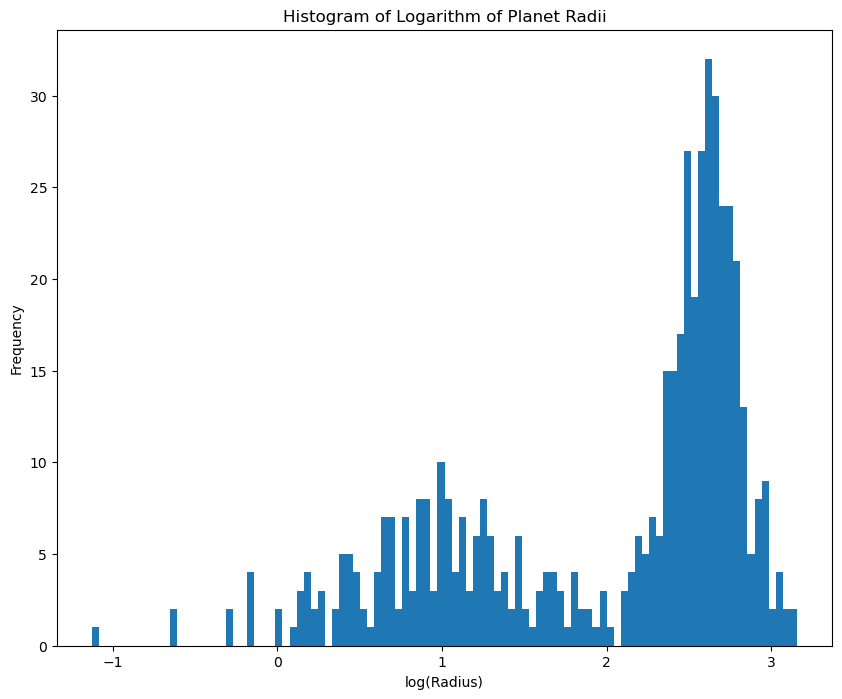

In [18]:
#We now repeat the analysis on the logarithmic scale
data_log = np.log(dplan['radius'])
#Let us plot the histogram of the radii:
plt.figure(figsize=(10, 8))
plt.hist(data_log, bins = 100)
plt.xlabel('log(Radius)')
plt.ylabel('Frequency')
plt.title('Histogram of Logarithm of Planet Radii')
plt.show()
#Clearly there are two groups of planet radii: Big planets and Small planets. 


In [19]:
#Fitting a Gaussian mixture model using pymc
#N = dplan_no_missing.shape[0]
#observed = dplan_no_missing['pl_radj']
N = len(data_log)
exoplanet_model = pm.Model()
with exoplanet_model:
    w1 = pm.Beta("w1", alpha = 1, beta = 1)
    thetas = pm.Normal("thetas", mu = np.array([1, 2.5]), sd = 3, shape = 2)
    sigmas = pm.HalfNormal("sigmas", sd = 3, shape = 2)
    category = pm.Bernoulli("category", p = w1, shape = N)
    mean_individual = thetas[category]
    sd_individual = sigmas[category]
    obs = pm.Normal("obs", mu = mean_individual, sd = sd_individual, observed = data_log)
    idata = pm.sample(1000, chains = 2, return_inferencedata = True)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [sigmas, thetas, w1]
>BinaryGibbsMetropolis: [category]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/stats/diagnostics.py:585: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/opt/conda/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [20]:
print(idata.posterior)
#Calculate posterior means of w1, thetas and sigmas:
w1_samples = idata.posterior['w1'].values.flatten()
w1mean = np.mean(w1_samples)

thetas_samples = idata.posterior['thetas'].values
combined_thetas_samples = thetas_samples.reshape(-1, 2)
print(combined_thetas_samples.shape)
thetas_means = np.mean(combined_thetas_samples, axis = 0)

sigmas_samples = idata.posterior['sigmas'].values
combined_sigmas_samples = sigmas_samples.reshape(-1, 2)
print(combined_sigmas_samples.shape)
sigmas_means = np.mean(combined_sigmas_samples, axis = 0)

print(w1mean, thetas_means, sigmas_means)

<xarray.Dataset>
Dimensions:         (chain: 2, draw: 1000, thetas_dim_0: 2, category_dim_0: 517, sigmas_dim_0: 2)
Coordinates:
  * chain           (chain) int64 0 1
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * thetas_dim_0    (thetas_dim_0) int64 0 1
  * category_dim_0  (category_dim_0) int64 0 1 2 3 4 5 ... 512 513 514 515 516
  * sigmas_dim_0    (sigmas_dim_0) int64 0 1
Data variables:
    thetas          (chain, draw, thetas_dim_0) float64 0.9648 2.595 ... 1.146
    category        (chain, draw, category_dim_0) int64 1 0 0 1 1 ... 0 0 0 0 0
    w1              (chain, draw) float64 0.6764 0.5803 0.6584 ... 0.3963 0.3845
    sigmas          (chain, draw, sigmas_dim_0) float64 0.5421 0.2091 ... 0.5964
Attributes:
    created_at:                 2023-09-21T22:13:15.775992
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              61.25861883163452
    tuning

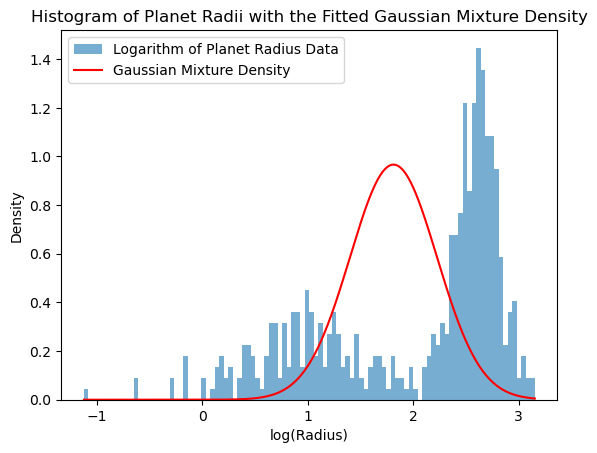

In [21]:
#Let us plot the fitted two component normal mixture density on the histogram (to visualize the fit):
from scipy.stats import norm

plt.hist(data_log, bins = 100, density = True, alpha = 0.6, label = 'Logarithm of Planet Radius Data')
x = np.linspace(min(data_log), max(data_log), 1000)
density = w1mean * norm.pdf(x, thetas_means[0], sigmas_means[0]) + (1-w1mean) * norm.pdf(x, thetas_means[1], sigmas_means[1])
plt.plot(x, density, 'r', label = 'Gaussian Mixture Density')
plt.title('Histogram of Planet Radii with the Fitted Gaussian Mixture Density')
plt.xlabel('log(Radius)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [22]:
category_samples = idata.posterior['category'].values
combined_samples = category_samples.reshape(-1, N)
print(combined_samples.shape)
category_means = np.mean(combined_samples, axis = 0)
category_sums = np.sum(combined_samples, axis = 0)
#print(category_sums)
print(category_means)

(2000, 517)
[0.505  0.5    0.5    0.4985 0.501  0.4985 0.5    0.5055 0.5035 0.5045
 0.4985 0.499  0.4975 0.4995 0.5065 0.5    0.498  0.5    0.5    0.501
 0.5    0.502  0.502  0.4985 0.499  0.503  0.5005 0.499  0.5    0.504
 0.5015 0.505  0.5    0.5    0.5    0.5    0.5    0.5    0.496  0.497
 0.502  0.4985 0.4965 0.484  0.505  0.4995 0.5005 0.486  0.5025 0.4935
 0.5005 0.497  0.5025 0.4985 0.4995 0.5025 0.501  0.509  0.4995 0.499
 0.4975 0.5045 0.5065 0.4995 0.4965 0.5075 0.497  0.501  0.5025 0.498
 0.5055 0.5045 0.4975 0.501  0.5005 0.5005 0.5005 0.5005 0.4985 0.5045
 0.5    0.505  0.502  0.502  0.4995 0.4985 0.501  0.497  0.5    0.4985
 0.4995 0.5005 0.5005 0.4975 0.495  0.5    0.4995 0.5005 0.499  0.512
 0.502  0.502  0.501  0.494  0.5005 0.5    0.5005 0.5015 0.502  0.499
 0.4975 0.498  0.5035 0.4995 0.501  0.4995 0.494  0.513  0.5025 0.5035
 0.507  0.5    0.502  0.4985 0.5    0.5    0.5    0.5    0.5015 0.5
 0.5    0.5    0.5005 0.4935 0.502  0.5    0.5    0.5    0.5    0.4985
 0.5

In [23]:
#Creating a Classification of Data Points based on the posterior mean of the category variable:
binary_class = (category_means > 0.5).astype(int)
dplan['classi'] = binary_class
print(np.mean(dplan['classi']))

0.3655705996131528


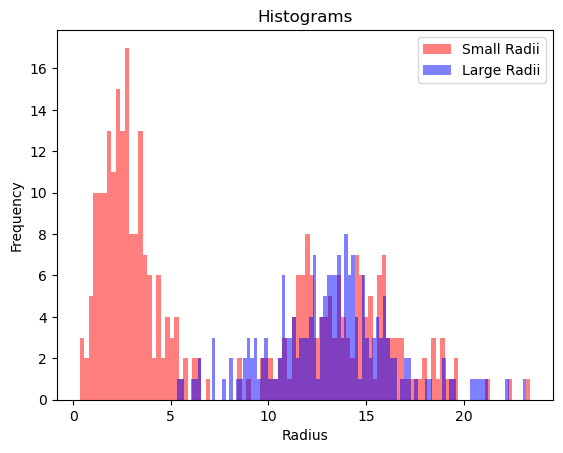

In [24]:
#Plotting two separate histograms in one plot
radius_zero = dplan[dplan['classi'] == 0]['radius']
radius_one = dplan[dplan['classi'] == 1]['radius']
plt.hist(radius_zero, bins = 100, color = 'red', alpha = 0.5, label = 'Small Radii')
plt.hist(radius_one, bins = 100, color = 'blue', alpha = 0.5, label = 'Large Radii')
plt.title('Histograms')
plt.xlabel('Radius')
plt.ylabel('Frequency')
plt.legend()
plt.show()                   

In [25]:
#Where is the cutoff?
print(np.max(radius_zero), np.min(radius_one))
#Thus planets with radii above the range 8.16 - 8.37 have been classified as large (and the rest as small) by this Bayesian Model. 
#For context, Jupiter's radius is about 11.2 times that of Earth so it will be classified as a large planet. 

23.426601 5.3018097


In [26]:
#What is the posterior probability of the second category (large) when radius equals 8.1600792 and
#when radius equals 8.3730483
print(dplan[dplan['radius'] == 8.1600792])
print(dplan[dplan['radius'] == 8.3730483])
print(category_means[262])
print(category_means[317])
#These values are quite close to 0.5 which means that the model is unclear as to whether these should be 
#classified as small or large. For the radius 8.1600792, it went with "small" with probability 55%
#For the radius 8.3730483, it went with "large" with probability 54%.

            name  orbital_period     mass    radius  star_temperature  \
262  Kepler-35 b         131.458  40.3606  8.160079            5606.0   

     density  classi  
262     0.41       1  
             name  orbital_period     mass    radius  star_temperature  \
317  Kepler-539 b       125.63243  308.266  8.373048            5820.0   

     density  classi  
317      2.9       1  
0.51
0.5085


# A study of some techniques for Monte Carlo Sampling

We have so far seen several examples of Bayesian Modeling using PyMC3. The output here is always in the form of posterior Monte Carlo samples. These samples can be used to approximate the underlying actual posterior distributions. We shall next spend some time exploring some sampling techniques that PyMC3 uses. We will not go into too much depth here and only study the most basic sampling algorithms. 

## Rejection Sampling

Rejection sampling is a very old method for obtaining Monte Carlo Samples. Suppose the goal is to obtain samples from a density $f_{\text{Target}}(u)$. Rejection sampling provides an algorithm for generating samples from $f_{\text{Target}}(u)$ using another density $f_{\text{Proposal}}(u)$. This proposal density should satisfy the following two properties: 
1. Obtaining samples from $f_{\text{Proposal}}(u)$ should be easy. 
2. There must exist a positive real number $M$ such that $$f_{\text{Target}}(u) \leq M f_{\text{Proposal}}(u)$$ for all values of $u$. Although the method will work, in principle, for any positive $M$ satisfying the above condition, it becomes extremely inefficient if $M$ gets large as will be clear below. So we want $M$ to satisfy the above condition and also to be not too large. 

Rejection Sampling is based on the following very simple (Bayesian) fact. Consider the following Bayesian model: 
\begin{align*}
    \text{Prior}: \Theta \sim f_{\text{Proposal}} ~~~ \text{ and } ~~~ \text{Likelihood}: Y \mid \Theta = u \sim \text{Bernoulli} \left(\frac{f_{\text{Target}}(u)}{M f_{\text{Proposal}}(u)} \right)
\end{align*}
So in this model, the unknown parameter $\Theta$ has the prior density $f_{\text{Proposal}}$. The data is binary and the likelihood is given by the Bernoulli distribution with parameter $\frac{f_{\text{Target}}(u)}{M f_{\text{Proposal}}(u)}$. Note that the Bernoulli parameter should be always between 0 and 1 which is why we need the condition $f_{\text{Target}}(u) \leq M f_{\text{Proposal}}(u)$ for all values of $u$. The key fact underlying Rejection Sampling is that the posterior density of $\Theta$ in this model given $Y = 1$ is exactly $f_{\text{Target}}$:
\begin{align*}
   \Theta \mid Y = 1  ~~ \sim f_{\text{Target}}
\end{align*}

5018


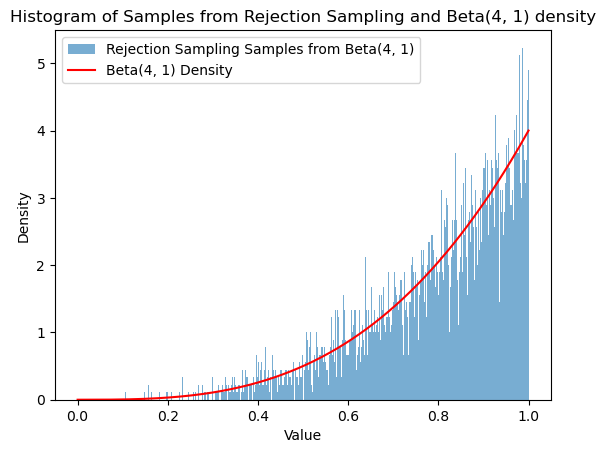

In [27]:
#Rejection sampling for generating samples from Beta(4, 1):
#Our proposal distribution will be Uniform[0, 1]
#The value of M can be taken to be the largest value of the density. 
M = 4
N = 20000 #this is the number of proposal samples that we will generate
prior_samples = np.random.rand(N)
p_prior_samples = prior_samples ** 3
Y_samples = np.random.binomial(n = 1, p = p_prior_samples)
posterior_samples = prior_samples[Y_samples == 1]
print(len(posterior_samples))
plt.hist(posterior_samples, bins = 500, density = True, alpha = 0.6, label = 'Rejection Sampling Samples from Beta(4, 1)') 
x = np.linspace(0, 1, 1000)
from scipy.stats import beta
pdf_values = beta.pdf(x, 4, 1)
plt.plot(x, pdf_values, 'r-', label = 'Beta(4, 1) Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Samples from Rejection Sampling and Beta(4, 1) density')
plt.show()
#The match between the histogram and the true density is not bad but we are only 
#getting about 1/4 of the total samples (others are rejected because of Y = 0).

2499


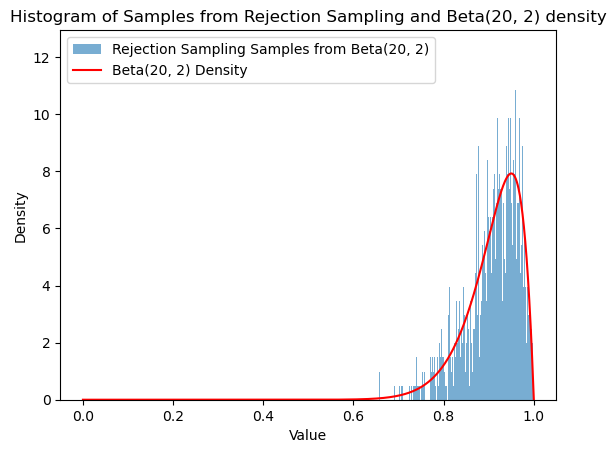

In [28]:
#Rejection sampling for generating samples from Beta(20, 2):
#Our proposal distribution will be Uniform[0, 1]
#The value of M can be taken to be anything larger than the largest value of the density. 
M = 8
N = 20000 #this is the number of proposal samples that we will generate
prior_samples = np.random.rand(N)
p_prior_samples = 420 * (prior_samples ** 19) * (1 - prior_samples) * (1/8)
Y_samples = np.random.binomial(n = 1, p = p_prior_samples)
posterior_samples = prior_samples[Y_samples == 1]
print(len(posterior_samples))
plt.hist(posterior_samples, bins = 500, density = True, alpha = 0.6, label = 'Rejection Sampling Samples from Beta(20, 2)') 
x = np.linspace(0, 1, 1000)
from scipy.stats import beta
pdf_values = beta.pdf(x, 20, 2)
plt.plot(x, pdf_values, 'r-', label = 'Beta(20, 2) Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Samples from Rejection Sampling and Beta(20, 2) density')
plt.show()
#The match between the histogram and the true density is not bad but we are only 
#getting about 1/8 of the total samples (others are rejected because of Y = 0).

In general, the marginal probability of $Y = 1$ in the rejection sampling Bayesian model equals $1/M$. So if $N$ samples are originally generated from the prior (proposal density), then we can expect to have about $N/M$ samples from the posterior (target density). Thus if $M$ is large, we will have very few samples from the target density. Thus the trick in Rejection Sampling is to choose the proposal density so that $M$ is not too large (this, of course, may not be always possible because the proposal density also needs to be one for which we can obtain samples easily). 